### Step 1: Importing the dependencies

In [3]:
import pandas as pd
import re
import pickle
import numpy as np
import tensorflow as tf
import tensorflow_text as text
import tensorflow_datasets as tfds
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from tensorflow.keras.layers import TextVectorization
import string
from nltk.tokenize import word_tokenize

# Download NLTK resources (stopwords and WordNet)
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

### Defining Parameters

In [4]:
# Shuffle and batch the dataset
batch_size = 32
seed = 42

# Vocabulary size and number of words in a sequence
vocab_size = 10000
sequence_length = 100

stop_words = tf.constant(stopwords.words('english'))

### Step 2: Creation of Questions dataframe
Currently there are 5 different files belonging to 5 different domain of the questions and in this module we will be creating a dataframe that will be having total of 1600 questions belonging to 5 different domains. The domains are
- DSA questions
- System design questions
- AI questions
- Computer fundamental questions
- Behavioural questions

In [ ]:
file_paths = ['../Dataset/DSA_que.txt', '../Dataset/System_Design_que.txt', '../Dataset/Behavioural_que.txt',
              '../Dataset/CS_fundamentals.txt', '../Dataset/AI_que.txt']
que_type = {0: 'DSA',
            1: 'System_design',
            2: 'Behavioural',
            3: 'CS_fundamentals',
            4: 'AI'}
count = 0
df = pd.DataFrame()

# Going over all the paths
for paths in file_paths:
    try:
        # Reset que_ls for each file iteration
        que_ls = []

        with open(paths, 'r') as file:
            lines = file.readlines()
            for line in lines:

                # Removing the leading and following white space after reading content from the file
                line = line.strip()

                # Saving the line in the que list
                que_ls.append(line)

            # Creating series from the
            que_sr = pd.Series(que_ls)
            temp_df = pd.DataFrame({'Que': que_sr})

            # Adding a feature 'Category'
            temp_df['Category'] = que_type[count]
            count = count + 1

            # Concatenating the dataframes
            df = pd.concat([df, temp_df], axis=0)

    except FileNotFoundError:
        print(f"The file {paths} was not found.")
    except Exception as e:
        print(f"An error occurred: {e}")

In [ ]:
# Shuffling the dataframe
df = df.sample(frac=1, random_state=42)

# Resetting the index
df.reset_index(drop=True,inplace=True)

In [ ]:
# Saving the dataframe
# df.to_csv('../Dataset/Que_Classification.csv')

### Exploratory data analysis
In this module our aim will be derive some useful insights from the questions belonging to differet domains and this analysis will further help us to decide what type of feature engineering we will do.

In [5]:
# Checking any 5 random rows from the dataframe
df = pd.read_csv('/content/Que_Classification.csv')
df.drop(['Unnamed: 0'],inplace=True,axis=1)
df.sample(5)

,Que,Category
1048,Tell me about a time when you had to navigate ...,Behavioural
438,How do you handle stress and pressure in a pro...,Behavioural
447,What measures would you take to ensure data co...,System_design
89,What is the role of the random forest algorith...,AI
955,Tell me about a time when you had to navigate ...,Behavioural


In [6]:
# Checking percentage of missinng values
df.isnull().mean()*100

Que         0.0
Category    0.0
dtype: float64

In [8]:
# Checking if there are any duplicate values
duplicate_counts = df.duplicated().sum()
if duplicate_counts > 0:

    # Storing all the duplicate data
    Duplicate_df = df[df.duplicated() == True]
    print("Duplicate values found and stored in dataframe, dataframe size : ",Duplicate_df.shape[0])
else:
    print("There are no duplicate values")

There are no duplicate values


In [7]:
# Removing the duplicate values
df.drop_duplicates(inplace=True)

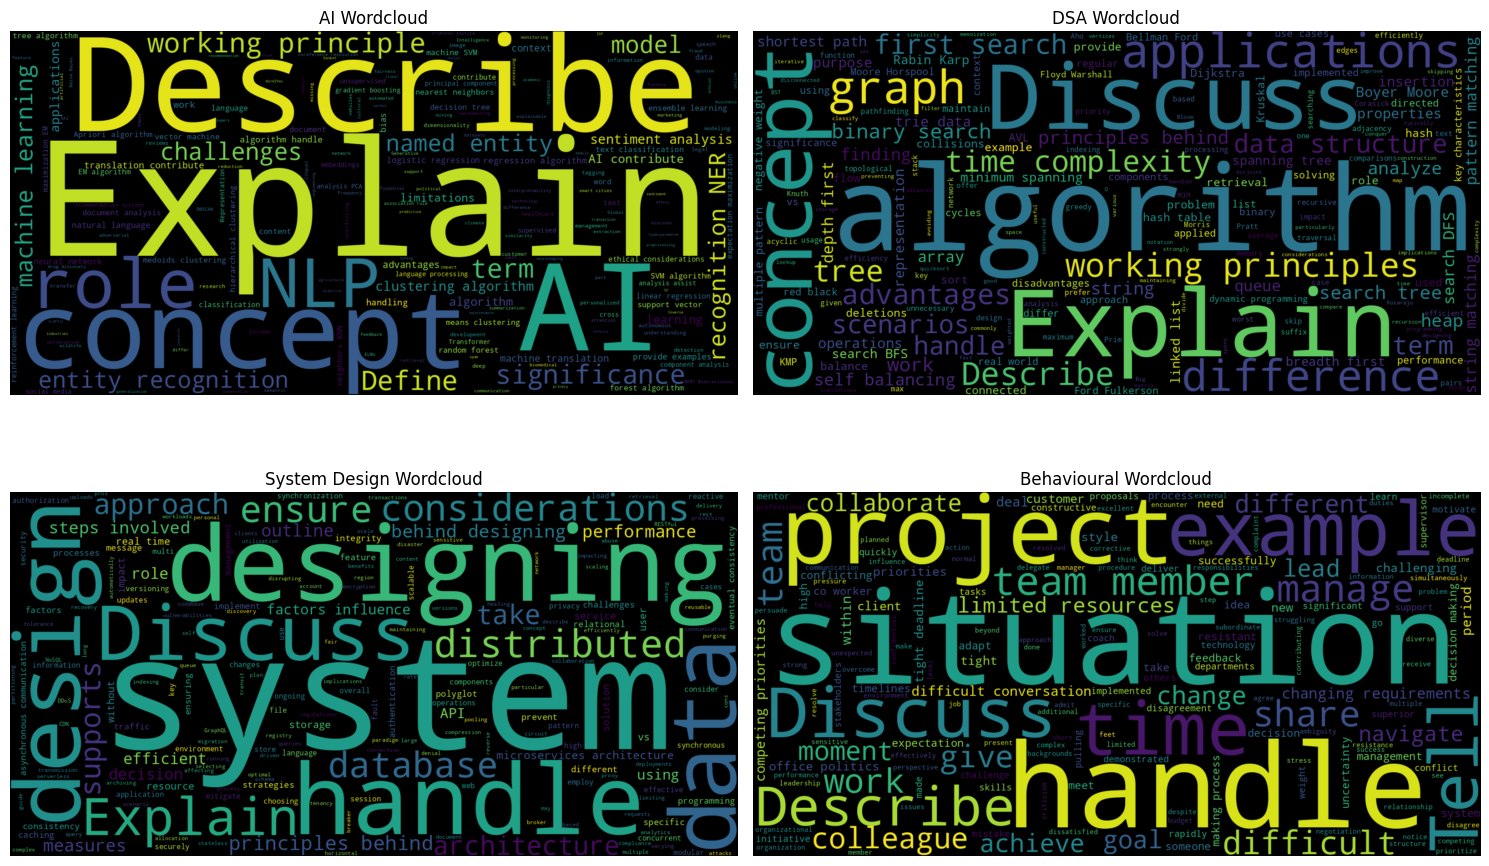

In [9]:
# Extracting the course titles and joining sentences into a single string
ai_que = df[df['Category'] == 'AI']['Que'].values
dsa_que = df[df['Category'] == 'DSA']['Que'].values
sd_que = df[df['Category'] == 'System_design']['Que'].values
beh_que = df[df['Category'] == 'Behavioural']['Que'].values

# Extracting all the questions into single string
ai_que_string = " ".join(ai_que.tolist())
dsa_que_string = " ".join(dsa_que.tolist())
sd_que_string = " ".join(sd_que.tolist())
beh_que_string = " ".join(beh_que.tolist())

# Set other parameters
wordcloud1 = WordCloud(width=1600, height=800).generate(ai_que_string)
wordcloud2 = WordCloud(width=1600, height=800).generate(dsa_que_string)
wordcloud3 = WordCloud(width=1600, height=800).generate(sd_que_string)
wordcloud4 = WordCloud(width=1600, height=800).generate(beh_que_string)

# Plotting
fig, ax = plt.subplots(2, 2, figsize=(15, 10))

ax[0, 0].imshow(wordcloud1, interpolation='bilinear')
ax[0, 0].set_title('AI Wordcloud')
ax[0, 0].axis('off')

ax[0, 1].imshow(wordcloud2, interpolation='bilinear')
ax[0, 1].set_title('DSA Wordcloud')
ax[0, 1].axis('off')

ax[1, 0].imshow(wordcloud3, interpolation='bilinear')
ax[1, 0].set_title('System Design Wordcloud')
ax[1, 0].axis('off')

ax[1, 1].imshow(wordcloud4, interpolation='bilinear')
ax[1, 1].set_title('Behavioural Wordcloud')
ax[1, 1].axis('off')

plt.tight_layout()
plt.show()

### Loading data to tensorflow dataset
Loading data into tf.data.Dataset offers several advantages and reasons why it's commonly used in TensorFlow pipelines:

- Efficient Memory Usage: TensorFlow dataset API provides efficient handling of large datasets by streaming data from disk or memory. It loads data on-the-fly, which is particularly useful when dealing with datasets that do not fit entirely into memory.

- Parallelism: TensorFlow's data API supports parallel data loading and preprocessing. This enables faster data pipeline execution, especially on multi-core CPUs or GPUs, as data loading and preprocessing can be performed in parallel with model training or inference.

- Data Transformation: tf.data.Dataset allows for easy and flexible data transformation and preprocessing. You can apply various transformations such as shuffling, batching, mapping, filtering, and more to the dataset to prepare it for training or inference.

In [10]:
# Perform one-hot encoding
one_hot_encoded = pd.get_dummies(df['Category'])
one_hot_encoded = one_hot_encoded.astype(int)

# Concatenate the one-hot encoded DataFrame with the original DataFrame
df = pd.concat([df, one_hot_encoded], axis=1)

# Dropping the Category attribute
df.drop(['Category'],axis=1,inplace=True)

In [11]:
# Creating TensorFlow Dataset directly from the DataFrame
raw_text_ds = tf.data.Dataset.from_tensor_slices((
    df['Que'],
    df[['AI', 'Behavioural', 'CS_fundamentals', 'DSA', 'System_design']]  # Target labels
))

# Shuffling the items
seed = 42
raw_text_ds = raw_text_ds.shuffle(len(df), seed=seed)

In [12]:
count = 1
for text,label in raw_text_ds:
    if count <= 5:
        print("Text "+str(count)+":",text)
        count = count + 1
    else:
        break

Text 1: tf.Tensor(b'Define the terms "caching" and "forwarding" in DNS.', shape=(), dtype=string)
Text 2: tf.Tensor(b'How do you ensure data consistency in a distributed database environment?', shape=(), dtype=string)
Text 3: tf.Tensor(b'Explain the concept of overfitting in machine learning.', shape=(), dtype=string)
Text 4: tf.Tensor(b'Define the term "IP address" and explain its structure.', shape=(), dtype=string)
Text 5: tf.Tensor(b'Describe the concept of a Bloom filter and its applications in data storage and retrieval.', shape=(), dtype=string)


In [13]:
count = 1
for text,label in raw_text_ds:
    if count <= 5:
        print("Label "+str(count)+":",label)
        count = count + 1
    else:
        break

Label 1: tf.Tensor([0 0 0 1 0], shape=(5,), dtype=int64)
Label 2: tf.Tensor([1 0 0 0 0], shape=(5,), dtype=int64)
Label 3: tf.Tensor([0 0 1 0 0], shape=(5,), dtype=int64)
Label 4: tf.Tensor([0 0 0 0 1], shape=(5,), dtype=int64)
Label 5: tf.Tensor([0 0 0 1 0], shape=(5,), dtype=int64)


### Data processing pipeline

Operations within TensorFlow preprocessing layers like TextVectorization get compiled into a static graph for performance optimizations. Thus Libraries like WordNetLemmatizer aren't designed for this graph context and might not operate correctly within it.

In [14]:
# Example to understand why we need to do lowercasing
word1 = "cat"
word2 = "Cat"
word2_lowercased = word2.lower()

def compare(word1,word2):
    if word1 == word2:
        print("Same")
    else:
        print("Differnt")

compare(word1,word2)
compare(word1,word2_lowercased)

Differnt
Same


In [15]:
# Remove stop words
def remove_stopwords(token):
    return tf.math.logical_not(tf.reduce_any(tf.math.equal(stop_words, token)))

In [16]:
def process_text(input_data):
    """
    Output: Cleaned text tensor

    Description: This function will take a single raw text as input, remove all stopwords and punctuation, then lowercase the words to eliminate any ambiguity.
    Ultimately clean text will be returned as a tensor.
    """

    # Lowercase the input data
    lowercase = tf.strings.lower(input_data)

    # Remove punctuation
    no_punctuation = tf.strings.regex_replace(lowercase, '[%s]' % re.escape(string.punctuation), '')

    # Tokenizing the words in the strings
    tokens = tf.strings.split(no_punctuation)

    filtered_tokens = tf.map_fn(remove_stopwords, tokens, fn_output_signature=tf.bool)

    # Filter tokens based on the boolean mask
    filtered_tokens = tf.boolean_mask(tokens, filtered_tokens)

    processed_text = tf.strings.reduce_join(filtered_tokens, separator=" ", axis=-1)
    return processed_text

In [17]:
# Cleaning all the texts
clean_train_ds = raw_text_ds.map(lambda x, y: (process_text(x), y))

In [18]:
count = 1
for text,label in clean_train_ds:
    if count <= 5:
        print("Text "+str(count)+":",text)
        count = count + 1
    else:
        break

Text 1: tf.Tensor(b'describe moment motivate team challenging period', shape=(), dtype=string)
Text 2: tf.Tensor(b'implement rate limiting system prevent abuse ensure fair resource allocation', shape=(), dtype=string)
Text 3: tf.Tensor(b'describe functionality router computer network', shape=(), dtype=string)
Text 4: tf.Tensor(b'describe role ai autonomous vehicles', shape=(), dtype=string)
Text 5: tf.Tensor(b'explain knearest neighbors knn algorithm advantages', shape=(), dtype=string)


### Train, test split + Data loading optimization

In [19]:
print("Total strings : ",len(raw_text_ds))
print("Total Training strings (80:20) : ",int(len(raw_text_ds)*0.8))
print("Total Testing strings : ",int(len(raw_text_ds)*0.2))

Total strings :  863
Total Training strings (80:20) :  690
Total Testing strings :  172


The performance of a dataset pipeline can have a significant impact on the performance of a machine learning model. If a dataset pipeline is slow, it can bottleneck the overall performance of the model. tfds.benchmark is a simple and easy-to-use tool for evaluating the performance of dataset pipelines. It can be used to identify bottlenecks, compare different pipelines, and track progress over time.

In [20]:
def create_train_test_val(ds,train_size,val_size):

    # Creating batch and also Calculating total batches
    ds = ds.batch(batch_size)
    total_batches = len(ds)

    # Extracting training,testing and validation batch from the dataset (ds)
    train_ds_batches = int(train_size*total_batches)
    test_ds_batches = int(val_size*total_batches)

    # 80:20
    train_ds = ds.take(train_ds_batches)
    test_ds = ds.skip(train_ds_batches).take(test_ds_batches)

    # Catching and prefetching the dataset to improve data pipeline performance
    train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
    test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

    return train_ds,test_ds


# Calling the function
train_ds,test_ds = create_train_test_val(raw_text_ds,0.8,0.2)

In [21]:
# Display some benchmark statistics
tfds.benchmark(train_ds)


************ Summary ************



  0%|          | 0/21 [00:00<?, ?it/s]

Examples/sec (First included) 147.57 ex/sec (total: 22 ex, 0.15 sec)
Examples/sec (First only) 9.18 ex/sec (total: 1 ex, 0.11 sec)
Examples/sec (First excluded) 522.90 ex/sec (total: 21 ex, 0.04 sec)


,duration,num_examples,avg
first+lasts,0.149084,22,147.567602
first,0.108923,1,9.180769
lasts,0.040161,21,522.896896


In [22]:
# Defining the text vectorization layer
vectorize_layer = TextVectorization(
    standardize=None,
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=sequence_length)

In [23]:
# Make a text-only dataset (no labels) and call adapt to build the vocabulary.
train_text_ds = clean_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text_ds)

In [24]:
# Get the learned vocabulary
vocabulary = vectorize_layer.get_vocabulary()

# Print the vocabulary
print("Vocabulary:", vocabulary)

Vocabulary: ['', '[UNK]', 'explain', 'describe', 'algorithm', 'concept', 'system', 'define', 'ai', 'role', 'handle', 'discuss', 'term', 'purpose', 'database', 'working', 'work', 'data', 'learning', 'significance', 'network', 'sql', 'time', 'analysis', 'applications', 'machine', 'team', 'designing', 'operating', 'tree', 'principles', 'nlp', 'contribute', 'search', 'example', 'context', 'systems', 'situation', 'project', 'principle', 'advantages', 'would', 'challenges', 'tell', 'recognition', 'memory', 'process', 'clustering', 'design', 'sentiment', 'networking', 'ner', 'named', 'entity', 'difference', 'management', 'file', 'performance', 'model', 'manage', 'language', 'key', 'difficult', 'considerations', 'behind', 'virtual', 'models', 'member', 'table', 'share', 'page', 'limitations', 'ensure', 'clause', 'statement', 'databases', 'translation', 'terms', 'string', 'graph', 'complexity', 'binary', 'architecture', 'use', 'text', 'queries', 'osi', 'document', 'distributed', 'differences', 

### Embedding layer in TensorFlow:

In TensorFlow, the tf.keras.layers.Embedding layer serves as a powerful tool for converting discrete integer word indices into dense, low-dimensional vector representations. These vectors capture semantic relationships between words, making them highly valuable for tasks like sentiment analysis, topic modeling, and machine translation.

**Key Characteristics**:

- Discrete Integer Input: The layer requires input in the form of positive integers, where each integer represents a unique word in your vocabulary.
- Vector Lookup: At its core, the embedding layer acts as a giant lookup table. For each integer input, it retrieves the corresponding pre-trained embedding vector from a massive matrix.
- Learnable Parameters: This embedding matrix holds the essential parameters that are learned during model training. As your model trains, these vectors automatically evolve to better represent word meanings and relationships within the context of your specific task.

**Pretrained or Learned Embeddings?**

TensorFlow's Embedding layer offers flexibility in how you create these vector representations:

- Pretrained Embeddings: You can leverage pre-trained embeddings from sources like Word2Vec, GloVe, or FastText. These embeddings are trained on large text corpora and often capture valuable semantic information. By loading them directly into your Embedding layer, you benefit from the knowledge encoded in these pre-trained vectors.
- Learned Embeddings: Alternatively, you can start with random values for the embedding matrix and let your model learn them dynamically during training. This approach is suitable for smaller datasets or if you want the embeddings to be specifically tailored to your task and domain.

**Choosing the Right Approach**: The choice between using pre-trained embeddings or learning them from scratch depends on several factors:

- Dataset Size: If you have a large dataset, pre-trained embeddings often provide a good starting point and can expedite training. For smaller datasets, learning embeddings from scratch might be necessary.
- Task Specificity: For tasks with specific domain knowledge, learning embeddings from scratch can potentially capture those nuances better.
    Computational Resources: Training large embedding matrices from scratch can be computationally expensive. Using pre-trained embeddings can alleviate this burden.

**Key Considerations**:

- Vocabulary Size: The embedding matrix dimension (number of vectors) is typically equal to the vocabulary size, so larger vocabularies lead to larger matrices and higher computational costs.
- Embedding Dimensionality: The dimensionality of each embedding vector determines the level of detail it can capture. Experimenting with different dimensions is often helpful to find a balance between information richness and model complexity.
- Non-static Embeddings: While TensorFlow's Embedding layer typically uses static (fixed) representations, newer approaches like word embeddings from contextual language models (e.g., BERT) provide context-aware representations that can further enhance performance.

In [25]:
clean_train_ds.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(5,), dtype=tf.int64, name=None))

In [26]:
# Adjusting the dimensions for the training
clean_train_ds = clean_train_ds.map(
    lambda x, y: (tf.expand_dims(x, axis=0), tf.reshape(y, (-1, 5))))


In [27]:
for text,label in clean_train_ds.take(1):
    print(label)

tf.Tensor([[0 0 0 0 1]], shape=(1, 5), dtype=int64)


In [28]:
# Define your model
model = tf.keras.Sequential([
    vectorize_layer,
    tf.keras.layers.Embedding(input_dim=len(vocabulary), output_dim=64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [29]:
history = model.fit(clean_train_ds, epochs=10, validation_data=test_ds)

Epoch 1/10
863/863 [==============================] - 103s 106ms/step - loss: 0.5028 - accuracy: 0.8100 - val_loss: 0.4389 - val_accuracy: 0.8500
Epoch 2/10
863/863 [==============================] - 79s 92ms/step - loss: 0.0476 - accuracy: 0.9838 - val_loss: 0.3808 - val_accuracy: 0.8687
Epoch 3/10
863/863 [==============================] - 80s 92ms/step - loss: 0.0058 - accuracy: 0.9977 - val_loss: 0.3726 - val_accuracy: 0.8813
Epoch 4/10
863/863 [==============================] - 80s 93ms/step - loss: 4.9405e-04 - accuracy: 1.0000 - val_loss: 0.4066 - val_accuracy: 0.8687
Epoch 5/10
863/863 [==============================] - 80s 92ms/step - loss: 2.2342e-04 - accuracy: 1.0000 - val_loss: 0.4374 - val_accuracy: 0.8625
Epoch 6/10
863/863 [==============================] - 80s 93ms/step - loss: 1.1573e-04 - accuracy: 1.0000 - val_loss: 0.4767 - val_accuracy: 0.8562
Epoch 7/10
863/863 [==============================] - 79s 92ms/step - loss: 6.3651e-05 - accuracy: 1.0000 - val_loss: 0.51

In [30]:
test_loss, test_acc = model.evaluate(test_ds)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

5/5 [==============================] - 0s 61ms/step - loss: 0.6226 - accuracy: 0.8438
Test Loss: 0.6226414442062378
Test Accuracy: 0.84375


In [31]:
class_labels = {
    0: "AI domain",
    1: "Behavioural domain",
    2: "CS fundamental domain",
    3: "DSA domain",
    4: "System design domain"
}


def predict_que_category(que):
    """
    This function takes a question as input and returns the predicted category.
    """

    # Creating tensor from the string
    Input_Que = tf.constant(que)

    # Cleaning the text
    Input_Que = process_text(Input_Que)

    # Fixing the input dimension
    Input_Que = tf.expand_dims(Input_Que, axis=0)

    # Getting predictions from the model
    predictions = model.predict(Input_Que)

    # Extracting the predicted class index (as a scalar)
    predicted_class_index = np.argmax(predictions, axis=1)[0]  # Access the first element

    # Mapping the index to the corresponding label
    return class_labels[predicted_class_index]

In [37]:
Input_question = input("Enter your question : ")
predict_que_category(Input_question)

Enter your question : What do you mean by OSI model ?
1/1 [==============================] - 0s 34ms/step


'CS fundamental domain'

In [38]:
# Saving the model
model.save('/content/Que_Classifier.keras')